# Chapter 3 : Object Tracking

**Team : Baptiste Hériard-Dubreuil, Jean-Baptiste Membrado**

In [1]:
import cv2 as cv
import numpy as np
import os
import math
import tarfile
import time as _time
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline

#Import all the extra you may need.

## 1 Video Processing and Detection. 

In this first part of chapter 3, you will be asked to construct a series of functions tools to handle video processing and basic detection. You will use the same HOG+SVM classifier from Chapter 2 and adapt it to handle video input.

In contrast to the previous assignments, in this assignment, we will not provide a guided skeleton of the function. You will use any high level (already implemented) function from OpenCV to complete the exercise specifications and outputs. In addition, you will be asked to search in the documentation (or your favourite reference) the specific usage of the functions. 

__Section Objectives:__

* Construct a Video processing pipeline.
* Use OpenCV functions on the video frames for human detection.
* Analyse and compare tracking methodes proposed by OpenCV

__Data__:

The chapter data included inside ``../data/videos`` folder contains three sample videos to test your functions.


### 1.1 Reading/Writing video

A video file can be abstracted as a bunch of images of the same dimensions in order (*i.e. collection*). Our first task is to complete the function `transform_video_file(...)` which will operate on every frames of a given video file. The following steps are required:

- Open video file
- Iterate overall frames or a subset of them (based on `n_frame` parameter)
- Apply the processing function. The function's signature needs to be `function(np.array, Any) -> Any`

To read videos you can use the OpenCV build-in functions, namely `cv::VideoCapture` class. More informations is available in the [docs](https://docs.opencv.org/3.4.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).


In [2]:
def transform_video_file(file_path, function, params=None, n_frame=-1):
    """
    Given the path of a video file (file_path) the function reads every frame of the input video and applies a given
    transformation (function) using the parameters (params)

    :input_image:       Input video file path 
    :function:          Function be applied to each frame of the image. Signature `function(np.array, Any) -> Any`
    :params:            Any parameter needed for the function above.
    :n_frame:           Maxiumum number of frame to read. Default `-1`, read all the content
    :return:            output_handler this can be anything you may need to save your results.
    """
    output_handler = []
    # Open video
    cap = cv.VideoCapture(file_path)
    if cap.isOpened():
        # This is the list where we store the transformed frames
        # This is the most general way to do it as we do not assume anything on the output format of the function 
        
        ret, frame = cap.read()
        index = 0
        while ret and index != n_frame:
            output_handler.append(function(frame, params))
        
            # ret is True if the frame is read correctly, and False if we arrived at the end of the video
            ret, frame = cap.read()
            index += 1
            
        
        return output_handler
     
    else:
        raise ValueError('Can not open file: {}'.format(file_path))
    # Close reader
    cap.release()
    # Return custom structure
    return output_handler

### 1.2 Example:

The example below shows how the `transform_video_file` can be used. It will open the video named `speaker.avi` and process only the first **2** frames.

In [3]:
# Example of usage:
def dummy_function(image, params):
    if('dummy_function' in params[0]):
        print('Func: "{}", Message "{}", File: "{}"'.format(params[0], params[1], params[2]))
        print('Image dims: {}'.format(image.shape))
    return 'I did it'
# Define parameters
file_name = '../data/videos/speaker.avi'
extra_params = ['dummy_function', 'Hello from the video file', file_name];

# Process single frame
transform_video_file(file_path=file_name, function=dummy_function, params=extra_params, n_frame=2)

Func: "dummy_function", Message "Hello from the video file", File: "../data/videos/speaker.avi"
Image dims: (720, 1280, 3)
Func: "dummy_function", Message "Hello from the video file", File: "../data/videos/speaker.avi"
Image dims: (720, 1280, 3)


['I did it', 'I did it']

### 1.3 Testing your function:

To test your function you need to process the video: ``../data/videos/video_gym.avi``. At each frame, you will count the number of __blue__ pixel. At the end you should return two outputs:

* The __frame number__ with the maximum number of blue pixels
* The __image__ frame with more blue pixels in greyscale, except for the blue pixels.

Display the image and the frame number. 

__Hint:__ Consider a blue pixel as any pixel in the range of the blue color in HSV: 
``([90,120,120]) , [130,255,255])``. 

__Hint 2__: Check the first assignment if you have no idea what am I talking about.  

In [4]:
def processing_fn(image, params):
    """
    Count the number of blue pixels in a given image. This function also extracts the region where the pixels are blue
    in form of a mask.
    
    :param image:  Frame to analyse
    :param params: Extra parameters that my be required by the functions
    """
    
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    lower_blue = np.array([90,120,120])
    upper_blue = np.array([130,255,255])
    mask = cv.inRange(hsv, lower_blue, upper_blue)
    res = cv.bitwise_and(image, image, mask=mask)
    
    blue_pixels = cv.countNonZero(mask)

    # Done
    return (blue_pixels, image, mask, res) # Magic structure with the number of blue pixels + mask


# Video file
file_path =  os.path.join('..','data', 'videos', 'video_gym.avi')
outputs = transform_video_file(file_path, processing_fn);

Frame with max blue pixels : 153 


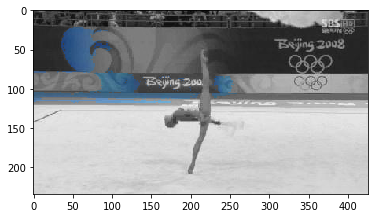

In [ ]:
frame_nb_max_blue = np.argmax(np.array(outputs)[:,0])
mask_max_blue = outputs[frame_nb_max_blue][2]

image = outputs[frame_nb_max_blue][1]
mask = outputs[frame_nb_max_blue][2] > 0
tmp = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
frame_augmented = cv.cvtColor(tmp, cv.COLOR_GRAY2BGR)
frame_augmented[mask] = image[mask]
display_image(frame_augmented);
print('Frame with max blue pixels : {} '.format(frame_nb_max_blue))

At each 30 seconds of the video, on its repectively frame (i.e. `frame_idx % 30 == 0`), show the following results

- Extracted mask
- Number of blue pixels counted


/home/baptiste/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


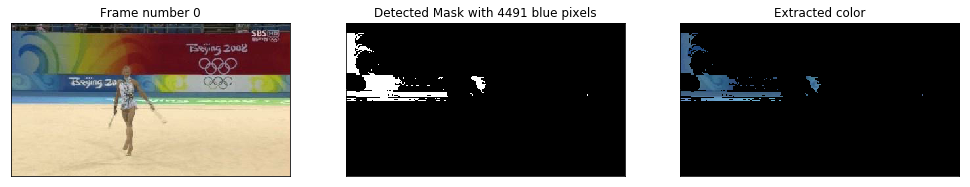

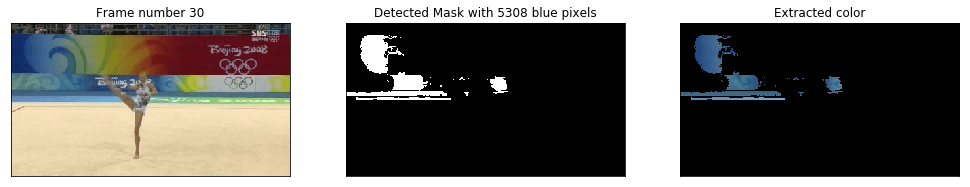

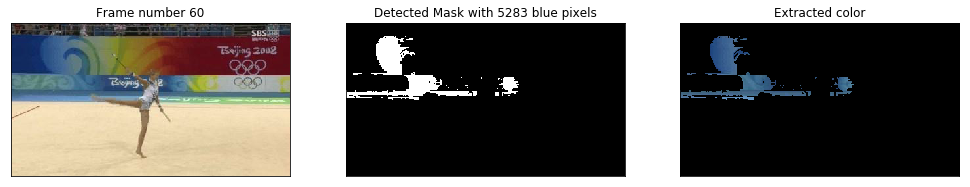

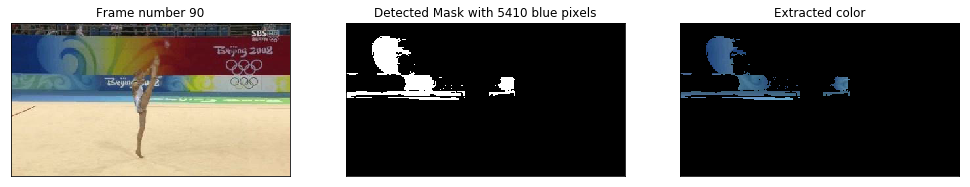

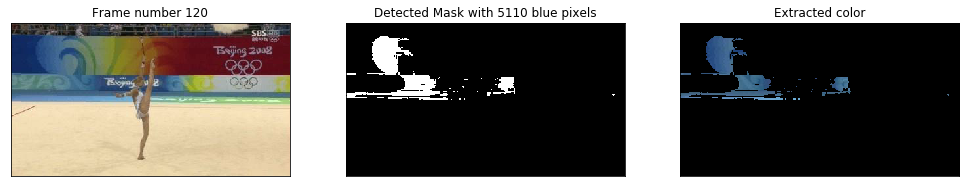

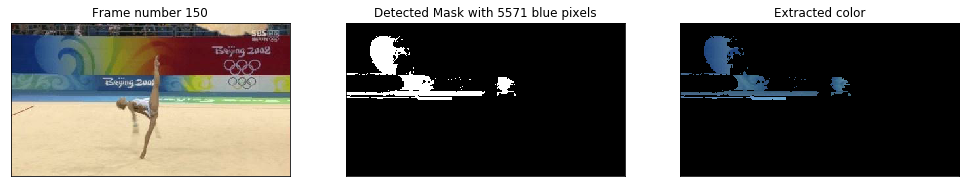

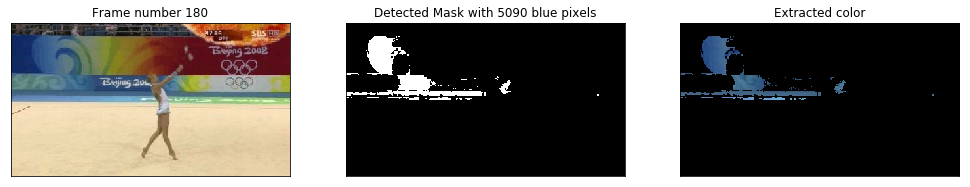

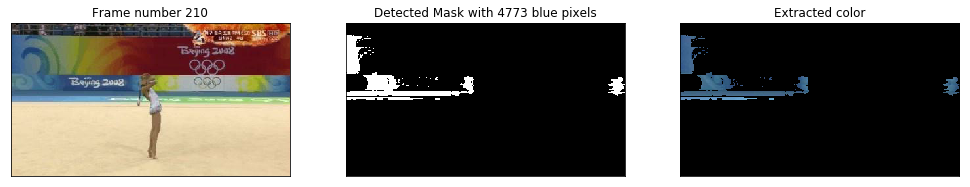

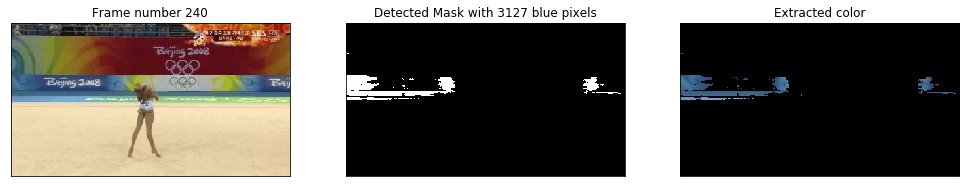

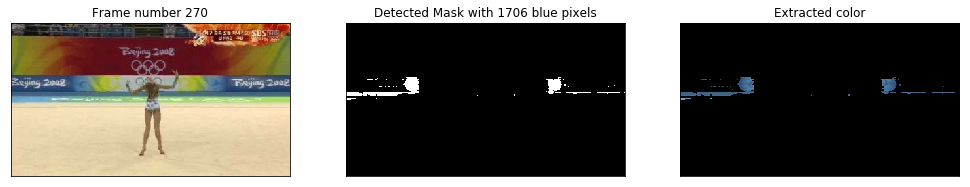

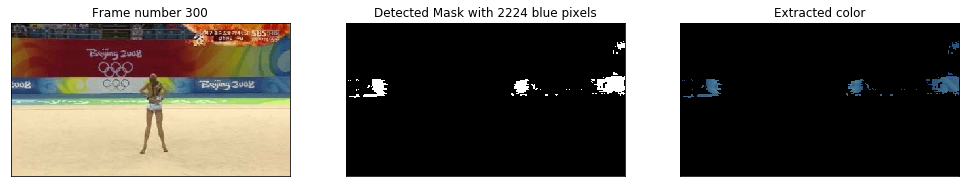

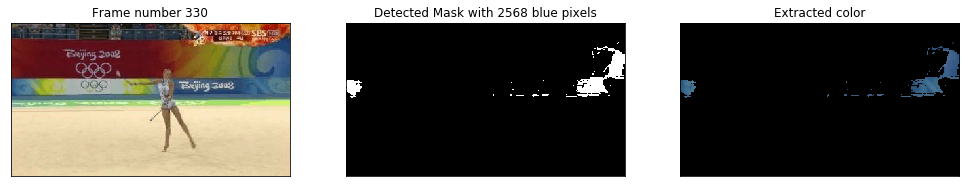

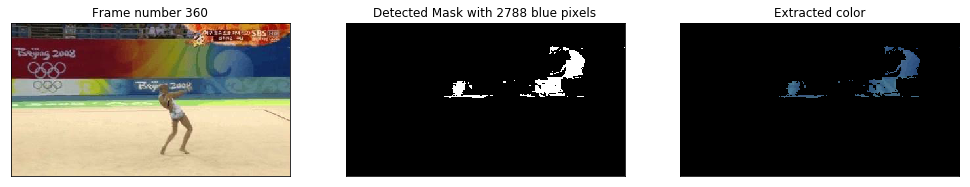

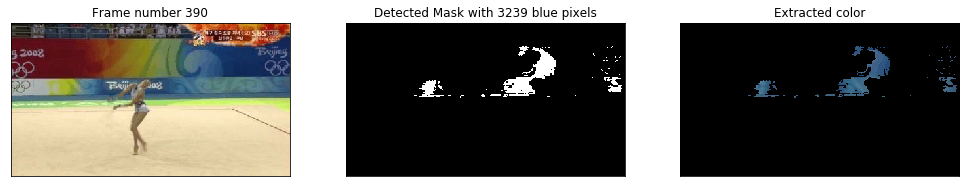

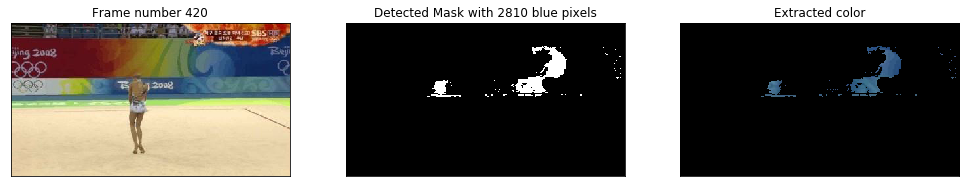

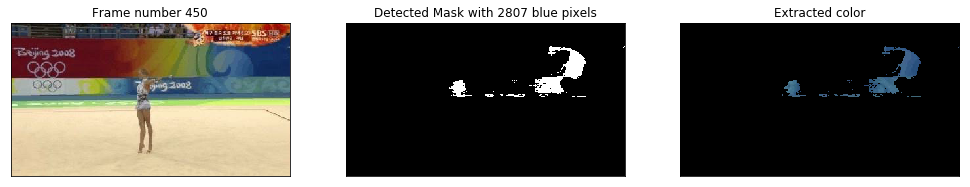

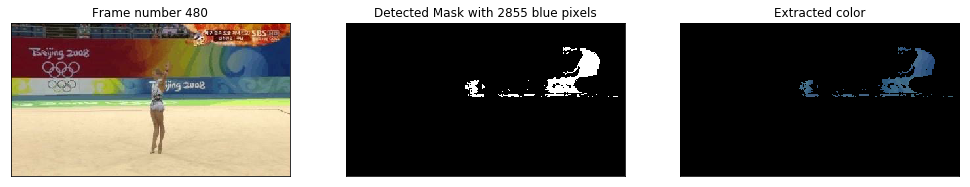

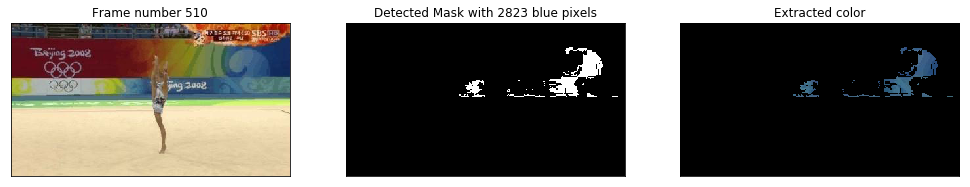

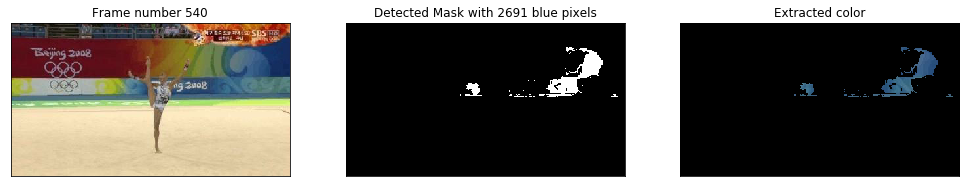

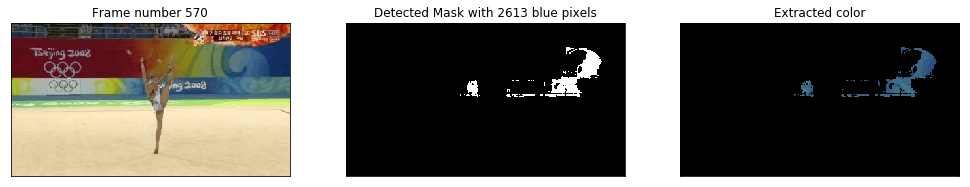

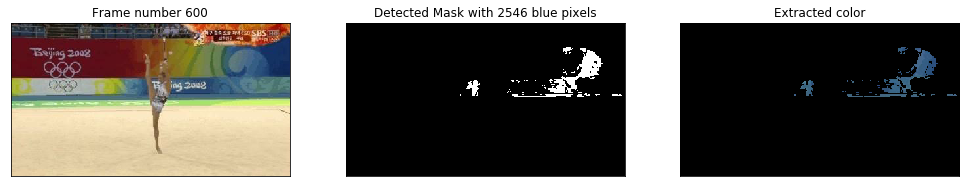

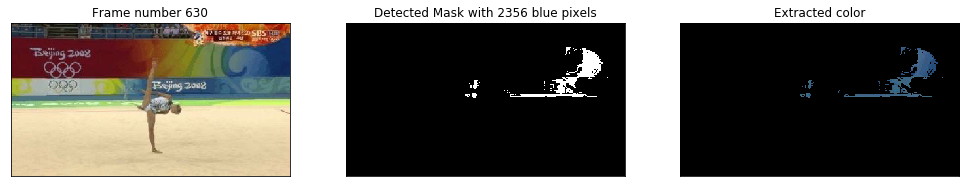

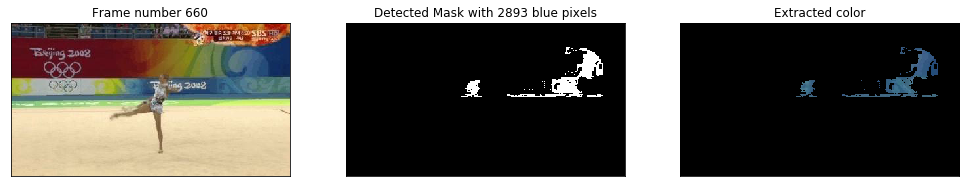

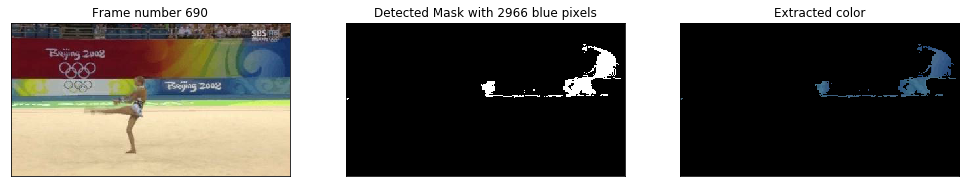

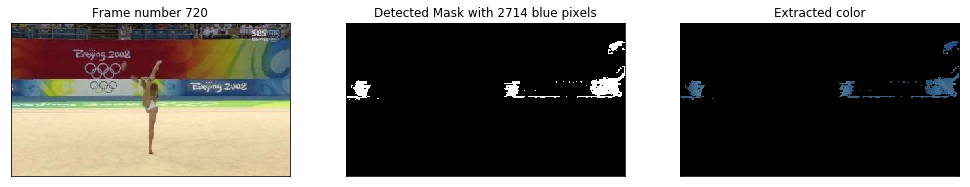

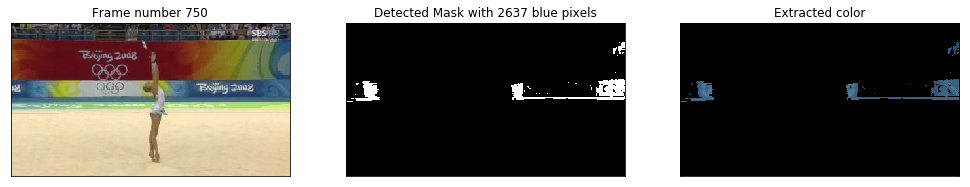

In [ ]:
# Plotting every 30 frame of the video, and extracting only the blue color of the frame
# Also, we count the number of blue pixels detected this way

for k in range(len(outputs)):
    if k%30==0:
        # print('Frame {} has {} blue pixels.'.format(k, outputs[k][0]))
        
        fig, ax = plt.subplots(1, 3, figsize=(17, 9))
        display_image(outputs[k][1], axes=ax[0])
        ax[0].set_title('Frame number {}'.format(k))
        ax[0].set_xticks([]) # Hide ticks since they're not very usefull in this context
        ax[0].set_yticks([])
        display_image(outputs[k][2], axes=ax[1], cmap='gray')
        ax[1].set_title('Detected Mask with {} blue pixels'.format(outputs[k][0]))
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        display_image(outputs[k][3], axes=ax[2])
        ax[2].set_title('Extracted color')
        ax[2].set_xticks([])
        ax[2].set_yticks([]); 

## Exercise 2: The return of the HOG.

Do you remember HOG? No? Well, it's okay, since all you need is to remember how to use it, here is a small reminder

Image has dimensions: (480, 640, 3)


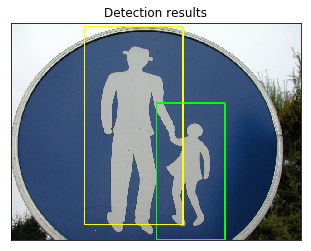

In [ ]:
# initialize the HOG descriptor/person detector
hog = cv.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# load base image (check that we are not scaling, normalizing or changing the channels)
img = cv.imread(os.path.join('..','data', 'person_454.bmp'))
print('Image has dimensions: {}'.format(img.shape))

# The HOG detector returns an array with the Regions of maximum likehood to contain a human-shaped-form
rects, weights = hog.detectMultiScale(img , winStride=(4, 4), padding=(8, 8), scale=1.05)

# draw the original bounding boxes
persons = 0;
for k, (x, y, w, h) in enumerate(rects):
    cv2.rectangle(img , (x, y), (x + w - 1, y + h -1), (0, 255, k * 256), 2)
    
display_image(img);
plt.title('Detection results')
plt.xticks([])
plt.yticks([]);

Finally, you will glue together your brand new image processing function and the HOG descriptor from OpenCV above.

### Testing your function:

To test your function you need to process the video: ``../data/videos/video_skater.avi``. At each frame, you will use HOG to detect any person in the frame. At the end of the function you should return: 

* The image __frame__ corresponding to __the seconds 1, 2, ... , 10__ of the video with the rectangle showing the "detected area". 

__Hint __: Check the second assignment if you have no idea what am I talking about.

__Be sure to display all the 10 frames for grading__


In [ ]:
def detection_fn(detector, image, params):
    """
    Run pedestrian detector on a given image.
    
    :param detector: HOG Detector instance
    :param image: Image to process
    :param params: Extra parameters needed by the function
    :return: Detected pedestrian bounding boxes
    """
    detector.setSVMDetector(cv.HOGDescriptor_getDefaultPeopleDetector())

    ws, pad, sc = params
    rects, weights = detector.detectMultiScale(image , winStride=ws, padding=pad, scale=sc)
        
    return (image.copy(), rects)
    
# Video file
parameters = ((2, 2), (0, 0), 1.05)
file_path =  os.path.join('..','data', 'videos', 'video_skater.avi')
outputs = transform_video_file(file_path, lambda im, p: detection_fn(hog, im, parameters), n_frame=350);

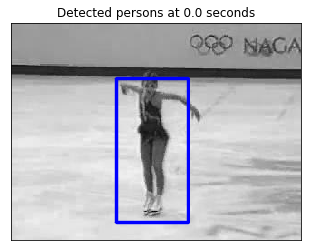

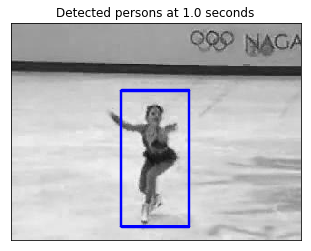

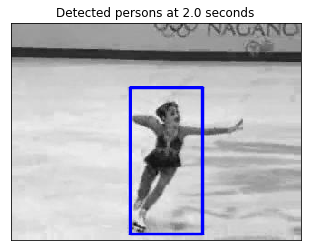

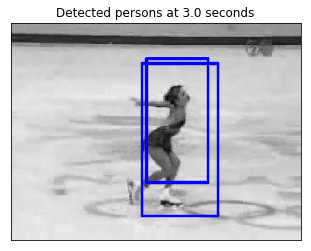

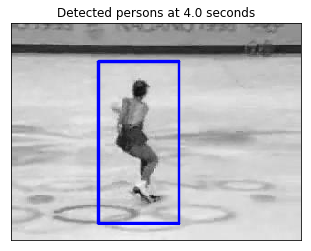

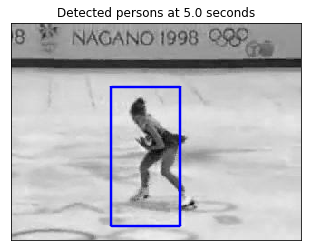

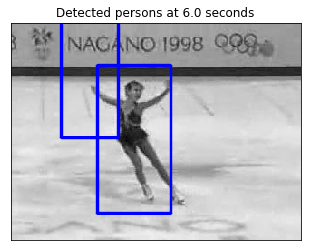

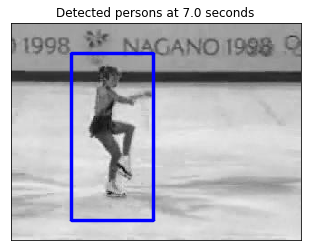

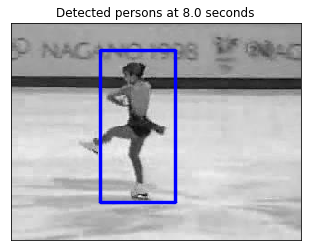

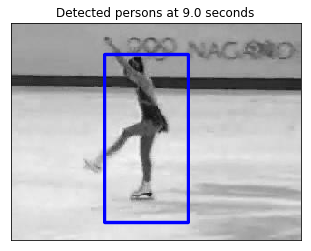

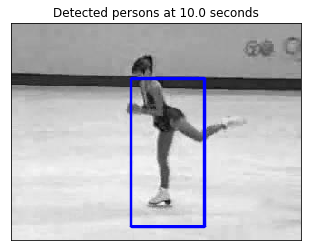

In [ ]:
cap = cv.VideoCapture(file_path)
if cap.isOpened():
    frameRate = int(cap.get(5))

for k in range(len(outputs)):
    if k%frameRate==0:
        
        im = outputs[k][0].copy()
        if len(outputs[k][1])>0:
            img, rects = outputs[k][0], outputs[k][1]
            for i, (x, y, w, h) in enumerate(rects):
                cv2.rectangle(im , (x, y), (x + w - 1, y + h -1), (255, 0, 0), 2, lineType=cv.LINE_AA)
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        display_image(im, axes=ax)
        ax.set_title('Detected persons at {} seconds'.format(k/frameRate))
        ax.set_xticks([]) # Hide ticks since they're not very usefull in this context
        ax.set_yticks([])

## 2 Face Tracking

Up to now, the frames of the video were considered as single image having no relationship between them. However, this is not the best approach: the correlation between two consecutive frames is large, since the image will displace or change in the next frame with respect to the previous one only by few pixels. We can rely on this to build a smarter detector. 

The case study for the next sections will be face tracking. The task is to provide a bounding box where the face is located. A number of methods will be analysed and benchmarked against each other. The baseline will be established with a standard face detector based on [Viola, Jones](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf) work (*i.e. no tracking*). Then, you will compare it against the tracking algorithms.

The methods to use and compare are the following:

- Frame-wise face detection (Baseline)
- Tracking: 'MIL', 'KCF', 'TLD', 'MedianFlow', 'Mosse'

For comparison, you will be asked  to implemented the following metrics:

- Euclidean distance between center's bounding box
- Intersection over Union
- Computation time

Your first task is to implement the preprocessing function that will be applied on every frame before actually doing the tracking. You can apply any transformation you want to each frames.

In [ ]:
# Load all images
def preprocessing_fn(image, params):
    """
    Apply preprocessing on a given image.
    
    :param image: Image to preprocess
    :param params: Extra parameters
    :return: Preprocessed image
    """
    # What pre processing to do ?
    
    return image

file_path =  os.path.join('..','data', 'videos', 'speaker.avi')
images = transform_video_file(file_path, preprocessing_fn, n_frame=350)
print('Video contains a total of {} frames'.format(len(images)))

### 2.2 Face Detection

The detection baseline is established using an instance of `cv::CascadeClassifier` which implements the approach proposed by Viola & Jones for object detection. 

Your task is to complete the implementation of the `detection_fn` which, given an instance of a classifier and an image, return the bounding box where the face is located. More information about the detector can be found in the [doc](https://docs.opencv.org/3.4.4/d1/de5/classcv_1_1CascadeClassifier.html#ab3e572643114c43b21074df48c565a27).

Be sure to implement a solution to deal with the situation where multiple boxes are returned by the classifier. The function must return **ONLY** one bounding box.

In [ ]:
def detection_fn(detector, image):
    """
    Run face detection on a given `image` with an instance of CascadeClassifier
    
    :param detector: CascadeClassifier instance
    :param image: Frame on which to run detection
    :return: bounding box if any or None
    """
    # Only one bounding box to return
    
    rects, numDet = detector.detectMultiScale2(image, 1.05, 5)
        
    # Selection for the best bounding box depending on the number of detections
    if len(rects) > 0:
        best_box = np.argmax(numDet)
        return rects[best_box]
    else:
        return None

The code in the following cell will test your `detection_fn` and display the outcome for the first four frames of the video.

In [ ]:
# Load face detector
fpath = os.path.join('..', 'data', 'haarcascade_frontalface_alt2.xml')
fdet = cv.CascadeClassifier(fpath)
assert fdet.empty() is not True

# Detect 
detection_out= []
for img in images[0:4]:
    bbox = detection_fn(fdet, img)
    detection_out.append(bbox)
    
# Display
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
for k, box in enumerate(detection_out):
    # Draw rectangle
    x, y, w, h = box
    im = cv.rectangle(images[k+100].copy(), (x, y), (x + w -1, y + h -1), (255, 0, 0), 3, lineType=cv.LINE_AA)
    # Display
    r = k // 2
    c = k % 2
    display_image(im, axes=ax[r][c])
    ax[r][c].set_title('Detection at frame {}'.format(k))
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([]);    

### 2.3 Face Tracking

Similar to what you have done before, you will have to complete the `tracking_fn` that will perform the tracking step. Given one instance of `cv::Tracker` [(doc)](https://docs.opencv.org/3.4.4/d0/d0a/classcv_1_1Tracker.html) and a  input image, the function will return the bounding box where the object (*i.e. face*) is located.

Again, be sure to **ONLY** one bounding box.

In [ ]:
def tracking_fn(tracker, image):
    """
    Perform tracking on a given image.
    
    :param tracker: Tracker instance
    :param image: Image on which to run tracker
    :return: Bounding box if any
    """
    
    retval, boundingBox = tracker.update(image)
    
    if retval:
        return boundingBox
    else:
        return None

The following cell will test your `tracking_fn` in the same way as what we did earlier b traking the first four frames of the video and displaying the results. 

In [ ]:
# Create tracker
tracker = cv.TrackerKCF_create()
# The line below was not working
# tracker =  create_face_tracker(name='KCF')
tracker.init(images[0], (551, 121, 153, 153))

# Detect 
tracking_out=[]
for img in images[:4]:
    bbox = tracking_fn(tracker, img)
    tracking_out.append(bbox)
           
# Display
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
for k, box in enumerate(tracking_out):
    # Draw rectangle
    x, y, w, h = box
    x = int(x); y=int(y); w=int(w); h=int(h)
    im = cv.rectangle(images[k].copy(), (x, y), (x + w -1, y + h -1), (0, 255, 0), 3, lineType=cv.LINE_AA)
    # Display
    r = k // 2
    c = k % 2
    display_image(im, axes=ax[r][c])
    ax[r][c].set_title('Tracking at frame {}'.format(k))
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([]);    

### 2.4 Comparison

#### 2.4.1 Metric

The performance of a given tracker will be assessed with the following metrics:

- Intersection over Union
- Distance between center's bounding boxes
- Execution time

##### 2.4.1.1 Intersection over Union

Your task is to complete the implementation of the `iou_metric` function. The function will return the *Intersection over Union* given two bounding boxes, namely `box_a` and `box_b`.

You can find the metric as the Jaccard index https://en.wikipedia.org/wiki/Jaccard_index. Feel free to modify the implementation below to adapt it to your function output.

In [ ]:
def iou_metric(box_a, box_b):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes (x, y, w, h)
    
    :param box_a: First bounding box
    :param box_b: Second bounding box
    :return: Intersction over Union
    """
    iou = 0.0
    
    
    # YOUR CODE HERE
    
    
    
    
    # return the intersection over union value
    return iou

In [ ]:
# Usage + sanity check
IoU = iou_metric(box_a=[39, 63, 164, 49], box_b=[40, 63, 165, 49])
print('Intersection over Union: {:.3f}'.format(IoU))
assert round(IoU, 3) == 0.982, 'Somehting went wrong at your implementation of the `iou_metric` function'

##### 2.4.1.2 Center's distance

Complete the `center_metric` function that compute the euclidean distance between two bounding box centers, define as:

$$
d_i = \left|\left| c_i^A - c_i^B \right|\right|
$$

where `A` and `B` are the two bounding boxes (*i.e. detection + ground truth*)


In [ ]:
def center_metric(box_a, box_b):
    """
    Compute the Euclidean distance between two given bounding boxes
    
    :param box_a: First bounding box
    :param box_b: Second bounding box
    :return: Distance
    """
    d = 0.0
    
    # YOUR CODE HERE

    return d
    

In [ ]:
# Usage + sanity check
dist = center_metric(box_a=[39, 63, 164, 49], box_b=[40, 63, 165, 49])
print('Distance: {:.3f}'.format(dist))
assert round(dist, 3) == 1.500, 'Somehting went wrong at your implementation of the `center_metric` function'

##### 2.4.1.3 Execution time

The function `time_metric` will measure the execution time of a given function defined in `processing_fn`. Its signature must be `processing_fn() -> Any`.
If the `processing_fn` return some values, they will be passed through the `time_metric` function. Therefore the return value is a tuple containing the execution time in first position and anything returned by `processing_fn` in the second position.

In [ ]:
def time_metric(processing_fn):
    """
    Measure the execution time of a given function (i.e. lambda function)
    
    :param processing_fn:  Lambda function to be timed
    :return: Execution time in milli-seconds
    """
    s0 = cv.getTickCount()
    retval = processing_fn()
    s1 = cv.getTickCount()
    return (1000.0 * (s1 - s0)) / cv.getTickFrequency(), retval

The `time_metric` function can be used as follow:


In [ ]:
# Using user define function with proper prototype
def wasting_time_func():
    _time.sleep(0.75)
    return 'Done'
    
# Call metric
dt, ret = time_metric(wasting_time_func)
print('User-defined function took: {:.3f} ms, with return value {}'.format(dt, ret))

In [ ]:
# Using lambda function 
dt, ret = time_metric(lambda: _time.sleep(0.5))
print('Lambda function took: {:.3f} ms'.format(dt))

#### 2.4.2 Load Ground Truth

The true bounding boxes are stored into the `data/videos/speaker_gt.txt` text file. Each line contains the true bounding box for the corresponding frame.

Your task is to complete the `load_ground_truth` that parses the file and return a list of boxes.

In [ ]:
def load_ground_truth(filename):
    """
    Load all detection stored into a given file
    
    :param filename: Path to the text file storing the ground truth
    :return: List of bounding boxes
    """
    bboxes = []
    
    
    # YOUR CODE HERE
    
    
    return bboxes

Load every face bounding boxes into a list

In [ ]:
# Load ground truth
fname = os.path.join('..', 'data', 'videos', 'speaker_gt.txt')
gt_bbox = load_ground_truth(filename=fname)
print('There is a total of {} bounding boxes'.format(len(gt_bbox)))


#### 2.4.3 Experimental setup

In the `run_experiment` function, given a list of pair `{Image, Ground truth}`, it will perform the tracking/detection on all images and run the various *metrics* that have been implemented earlier. 

The results for a **single** frame will be stored into a dictionary with the following entries:

- `bbox` will contain the detected region
- `metrics` will contain all the metrics computed during the experiment. The metrics are stored in a `tuple` ordered as : `IoU, Distance, Time`


The next cells run the experiment with the `detection_fn` in order to establish the baseline. Later, on the tracking results, all the metrics will be compared against it.

In [ ]:
def run_experiment(images, true_bbox, tracking_fn):
    """
    Run a given detection/tracking function on a list of images.
    
    :param images: List of consecutive images to processed (already preprocessed)
    :param bboxes: List of true bounding boxes (Ground truth)
    :param tracking_fn: Function running detection/tracking for ONE frame
    :return: List of dictionnaries for each frames holding detected bounding box if any and the various metrics
    """
    metrics = []
    for img, gt_bbox in zip(images, true_bbox):
        # Run metrics + tracking
        dt, bbox = time_metric(lambda: tracking_fn(img))        
        iou = iou_metric(bbox, gt_bbox)
        dist = center_metric(bbox, gt_bbox)
        # Accumulate results
        metrics.append({'bbox': bbox, 'metric': (iou, dist, dt)})
    # Done
    return metrics

# Run detection, no tracking
detection_exp = run_experiment(images=images, true_bbox=gt_bbox, tracking_fn=lambda x: detection_fn(fdet, x))

Your task is to run the same experiment (*i.e. `run_experiment`*) for all the selected trackers. To instantiate the tracker using its name, you have to use the function `create_face_tracker(str) -> cv::Tracker`.

For the initialisation of the tracker, you can use the region: `(551, 121, 175, 175)`.

In [ ]:
# List of tracker to use
trackers_name = ['MIL', 'KCF', 'TLD', 'MedianFlow', 'Mosse']
# Run experiments for each tracker
trackers_exp = {}
for name in trackers_name:
    

    # YOUR CODE HERE
    


#### 2.4.4 Results

In this section we ask you to display and discuss about the outcome of the tracking experiments. Compare every tracker with the baseline established earlier and discuss what you observed.

Report the following quantities:

- The `min`, `max`, `mean`, `std` of each metrics for every tracker and the baseline, comment on the values
- Display the detection/tracking of the `best` and the `worst` IoU for each algorithm
- Discuss the performance of each tracker
- Discuss the pros and cons of each metrics
- Investigate each tracker and explain briefly what is the methods used under the hood.


In [ ]:

# YOUR CODE HERE
